In [22]:
import sys,os
import tarfile
import warnings

import numpy as np
import pandas as pd
import xarray as xr

import SDFC.link as sdl
import NSSEA as ns
import NSSEA.plot as nsp
import NSSEA.models as nsm
import scipy.stats as sc
import statsmodels.api as sm

import cProfile
import pstats
from pstats import SortKey


import cftime

import seaborn as sns
import time as tm
import pygam as pg

import multiprocessing as mp
print("Number of processors: ", mp.cpu_count())

from datetime import datetime
import warnings
warnings.filterwarnings('ignore')
# datetime object containing current date and time
now = datetime.now()
 
# dd/mm/YY H:M:S
dt_string = now.strftime("%m%d%H%M")
print( dt_string)

Number of processors:  8
08241125


In [23]:
np.random.seed(int(dt_string))

In [24]:
#A adapter, charge les fonctions
#%run '/home/barbauxo/Documents/Doctorat/03_Travail/2023_01 Application Tricastin/Scripts/data_preparation.py'
#%run '/home/barbauxo/Documents/Doctorat/03_Travail/2023_01 Application Tricastin/Scripts/Interest_Quantities.py'

%run "Utils/01Charge_Utils.py"

Number of processors:  8


In [26]:
#PAths to adapt
basepath=os.path.abspath(os.getcwd())
pathInp='./Data'



pathOut=os.path.join(basepath,'./Outputs/',dt_string)
if not os.path.exists(pathOut):
    os.makedirs(pathOut)
assert(os.path.exists(pathInp))



type_data="03_Post_treatment"  #"02_Selected" #"03_Post_treatment" #But no absolute temp


In [27]:
#Bayes arg

n_sample    = 100 #N tirage X
burn_in=1000
n_val_MCMC=10 #Number kept from each MCMC (Total tirages Kept =1000)




In [28]:


time_period    = np.arange( 1850 , 2101 , 1 , dtype = np.int )
time_reference = np.arange( 1986 , 2016 , 1 , dtype = np.int )

ci          = 0.05
sample_dis=False #If want n sample of each GCM model. For graph only, not used for multisynthesis. Takes a lot of time

#Time period of interest
T=100
T1=2000
T2=2100
deb=1850
fin=2101


## Some global parameters
##=======================

#bayes_kwargs = { "n_mcmc_drawn_min" :  5000 , "n_mcmc_drawn_max" : 10000 }
 
#test
#ns_law      =nsm.GEV(shape_cst = False )
ns_law      = nsm.GEV()
event       = ns.Event( "HW19" , 2019 , time_reference , type_ = "value" , variable = "TX3X" , unit = "K" )
verbose     = "--not-verbose" not in sys.argv

In [29]:
#Load Data (Post-treatment and anomaly)

lX,lY,models=load_models_CMIP6(pathInp,type_data)
Xo,Yo=load_obs(pathInp,type_data)
event.value = float(Yo.loc[event.time])

['ACCESS-CM2_i1p1f1', 'ACCESS-ESM1-5_i1p1f1', 'CMCC-ESM2_i1p1f1', 'CNRM-CM6-1-HR_i1p1f2', 'CNRM-CM6-1_i1p1f2', 'CNRM-ESM2-1_i1p1f2', 'CanESM5_i1p2f1', 'EC-Earth3-CC_i1p1f1', 'EC-Earth3-Veg-LR_i1p1f1', 'EC-Earth3-Veg_i1p1f1', 'EC-Earth3_i1p1f1', 'FGOALS-g3_i1p1f1', 'GFDL-ESM4_i1p1f1', 'HadGEM3-GC31-LL_i1p1f3', 'HadGEM3-GC31-MM_i1p1f3', 'INM-CM4-8_i1p1f1', 'INM-CM5-0_i1p1f1', 'IPSL-CM6A-LR_i1p1f1', 'KACE-1-0-G_i1p1f1', 'MIROC-ES2L_i1p1f2', 'MIROC6_i1p1f1', 'MPI-ESM1-2-LR_i1p1f1', 'MRI-ESM2-0_i1p1f1', 'MRI-ESM2-0_i2p1f1', 'NESM3_i1p1f1', 'NorESM2-MM_i1p1f1', 'TaiESM1_i1p1f1', 'UKESM1-0-LL_i1p1f2']


In [8]:
t0 = tm.time()





## Define clim variable from input
##================================
clim = ns.Climatology( event , time_period , models ,n_sample  , ns_law )
Xebm   = ns.EBM().draw_sample( clim.time , n_sample + 1 , fix_first = 0 )

In [9]:
clim =covariates_FC_GAM_pygam_light( clim , lX ,  Xebm , dof = 7 , verbose = False )
clim = nslaw_fit_light( lY , clim , verbose = verbose ) 
clim = infer_multi_model_light( clim , verbose = verbose )



params = ns.build_params_along_time( clim , verbose = verbose )
clim.to_netcdf( os.path.join( pathOut , ("clim_"+dt_string+".nc")  ) )


nslaw_fit                 (100.0%) [##########################################]
infer_multi_model         (100.0%) [##########################################]
build_params_along_time   (100.0%) [##########################################]


In [10]:
clim.law_coef.loc[:,"BE","Multi_Synthesis"]

<xarray.DataArray 'law_coef' (coef: 5)>
array([-0.44495259,  1.39274579,  0.58763335,  0.0033883 , -0.24050925])
Coordinates:
    model    <U23 'Multi_Synthesis'
    sample   <U4 'BE'
  * coef     (coef) <U6 'loc0' 'loc1' 'scale0' 'scale1' 'shape0'

In [11]:
## Add constraint on X
clim_light_MM = clim.copy()
clim_light_MM.keep_models( "Multi_Synthesis" )
clim_CX     = ns.constrain_covariate( clim_light_MM , Xo , time_reference , verbose = verbose )

params_CX = ns.build_params_along_time( clim_CX , verbose = verbose )
clim_CX.to_netcdf( os.path.join( pathOut , ("clim_CX_"+dt_string+".nc")  ) )

clim_CX.law_coef.loc[:,"BE",:]

constrain_covariate       (100.0%) [##########################################]
build_params_along_time   (100.0%) [##########################################]


<xarray.DataArray 'law_coef' (coef: 5, model: 1)>
array([[-0.44495259],
       [ 1.39274579],
       [ 0.58763335],
       [ 0.0033883 ],
       [-0.24050925]])
Coordinates:
  * model    (model) <U23 'Multi_Synthesis'
    sample   <U4 'BE'
  * coef     (coef) <U6 'loc0' 'loc1' 'scale0' 'scale1' 'shape0'

constrain_law             (99.01%) [######################################### ]
build_params_along_time   (100.0%) [##########################################]


<xarray.DataArray 'law_coef' (coef: 5, model: 1)>
array([[-0.31734791],
       [ 1.33891388],
       [ 0.43615094],
       [ 0.04470499],
       [-0.21685951]])
Coordinates:
  * model        (model) <U15 'Multi_Synthesis'
  * coef         (coef) <U6 'loc0' 'loc1' 'scale0' 'scale1' 'shape0'
    sample_MCMC  <U6 'BE'

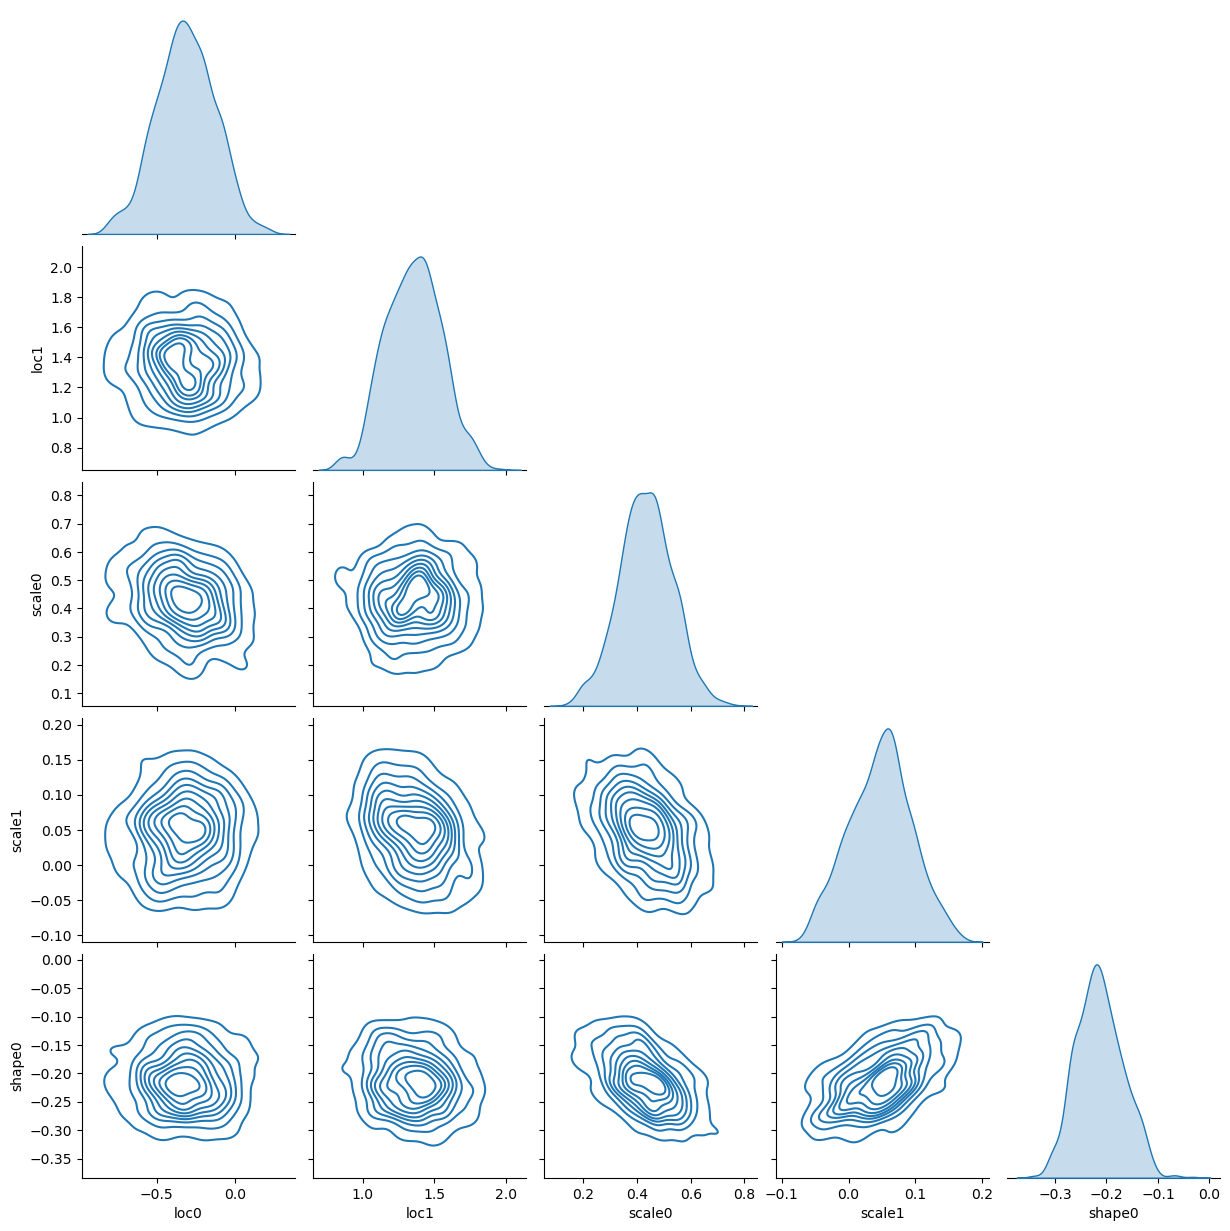

In [12]:
name="Clim_CXCB_MHWG_"+dt_string
clim_CXCB_MHWG=constrain_MCMC_MHWG_law_all( clim_CX, Yo,pathOut,name,TransitionAdapt=True,n_sortie=n_val_MCMC)

paramsCXCB_MHWG = build_params_along_time_fixed( clim_CXCB_MHWG , verbose = verbose )
clim_CXCB_MHWG.to_netcdf( os.path.join( pathOut , ("clim_CXCB_MHWG_"+dt_string+".nc")  ) )
t1 = tm.time()
clim_CXCB_MHWG.law_coef.loc[:,"BE",:]


In [13]:
clim.ns_law.get_params_names()

['loc0', 'loc1', 'scale0', 'scale1', 'shape0']

In [14]:
clim.ns_law.n_ns_params

5

In [15]:
total = t1-t0
print(total)

520.8605062961578


In [16]:
for p,s in zip([params,params_CX,paramsCXCB_MHWG],["","CX","CXCB_MHWG"]):
    p.to_dataset( name = "params{}".format(s) ).to_netcdf( os.path.join( pathOut, ("params{}_"+dt_string+".nc").format(s) ) )


In [17]:
%run "Figures_Utils/For_One.py"

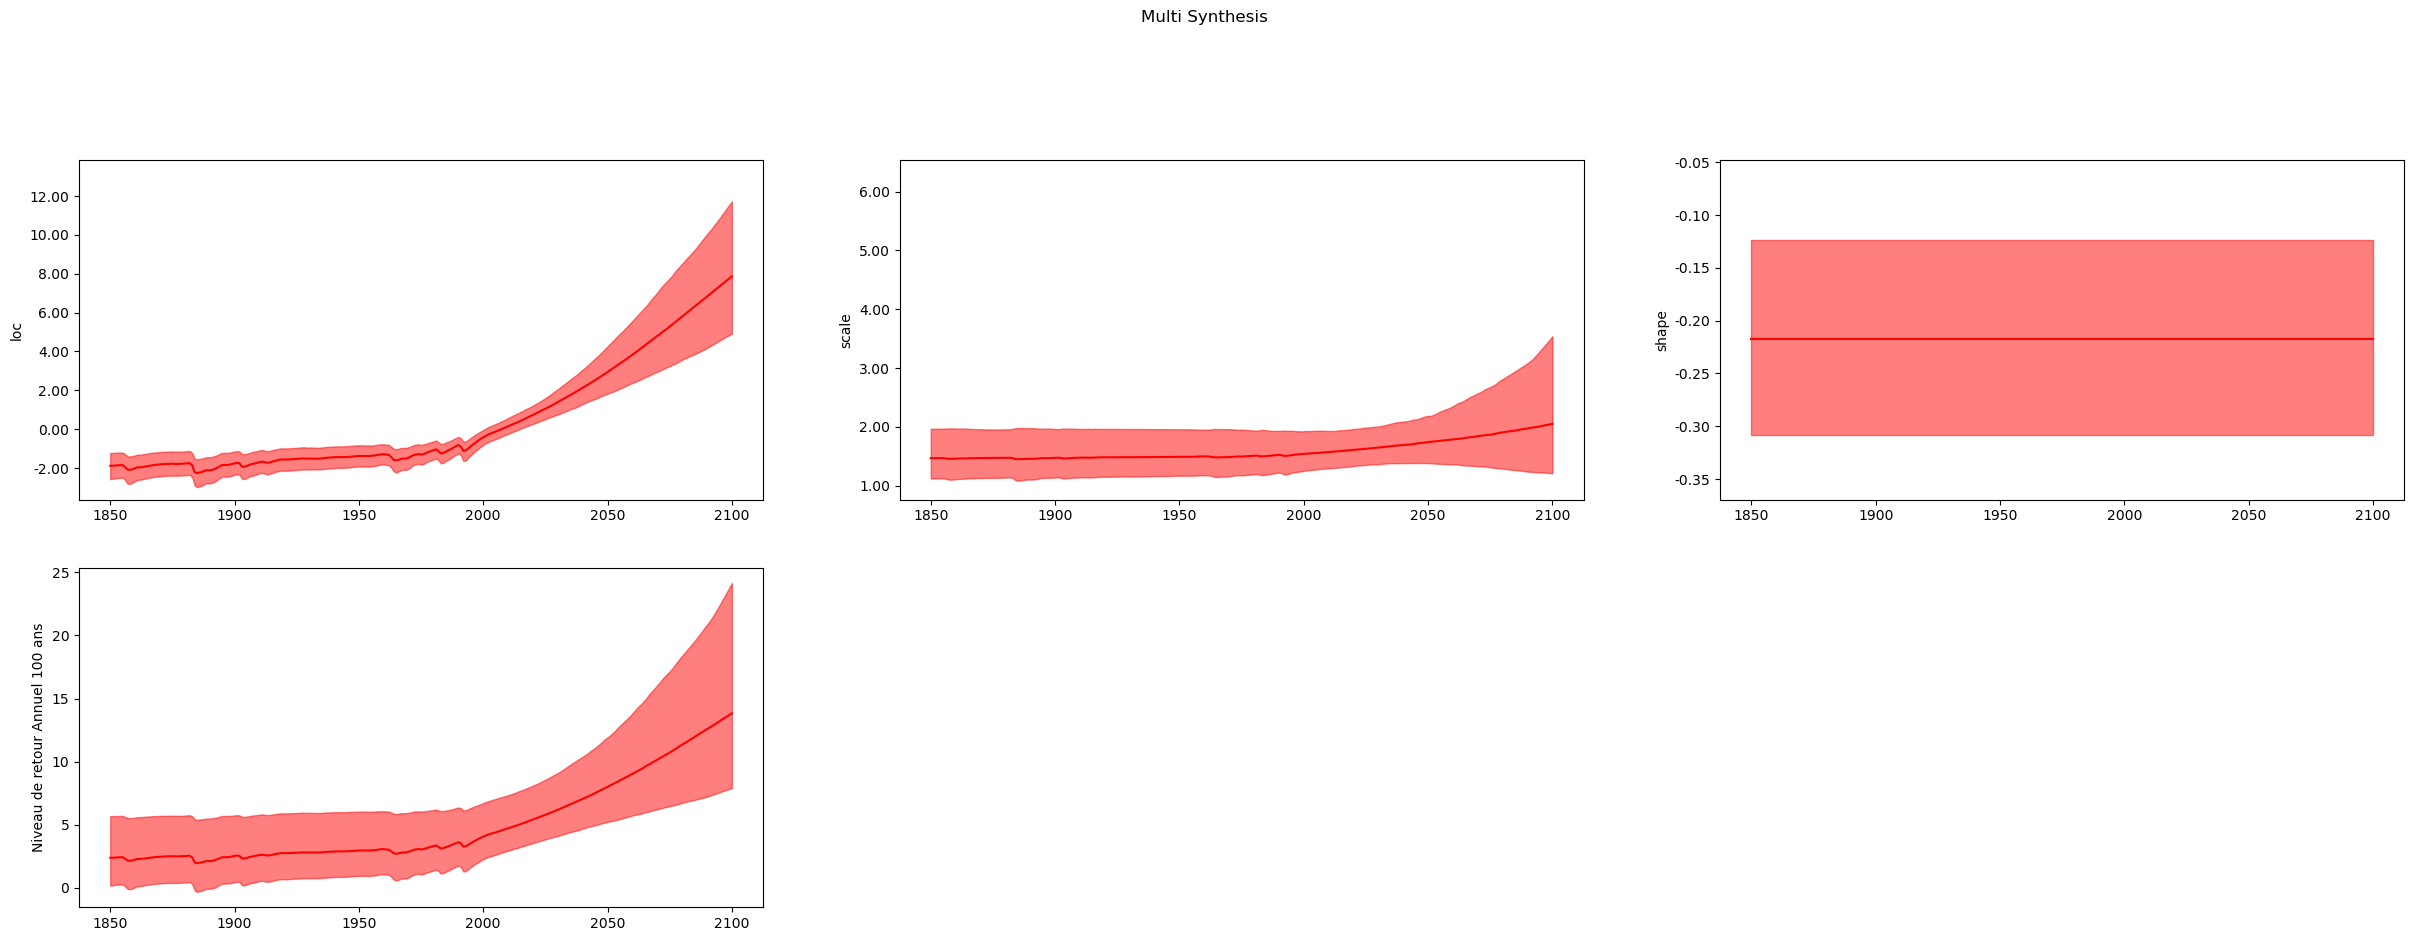

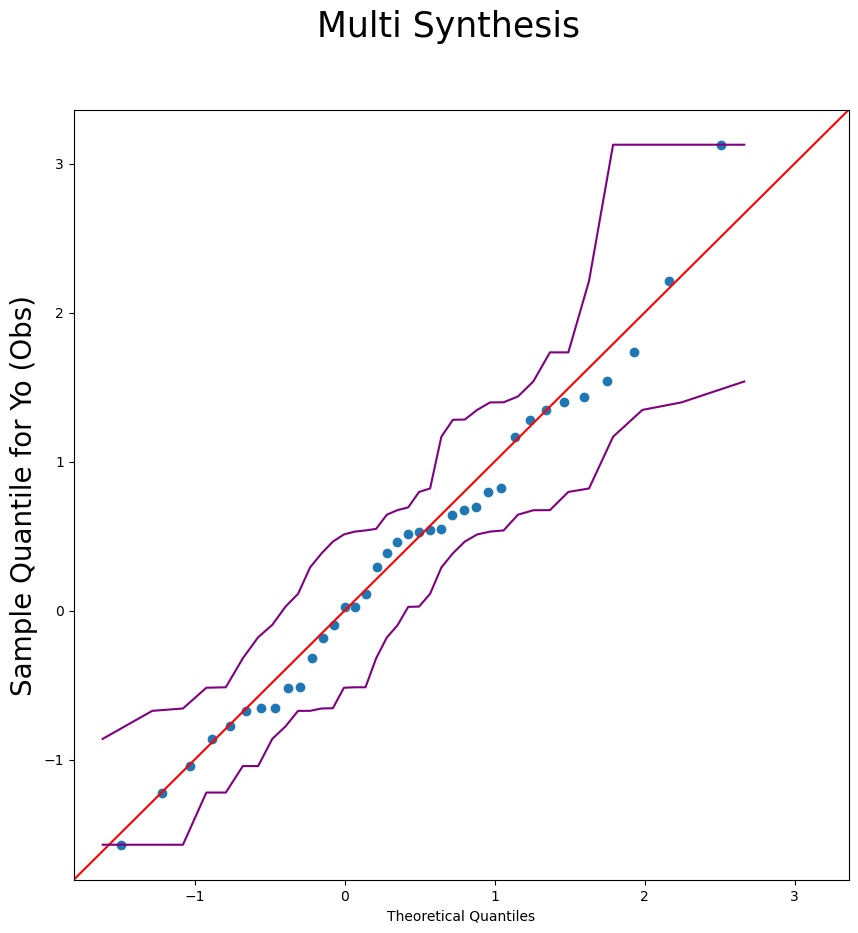

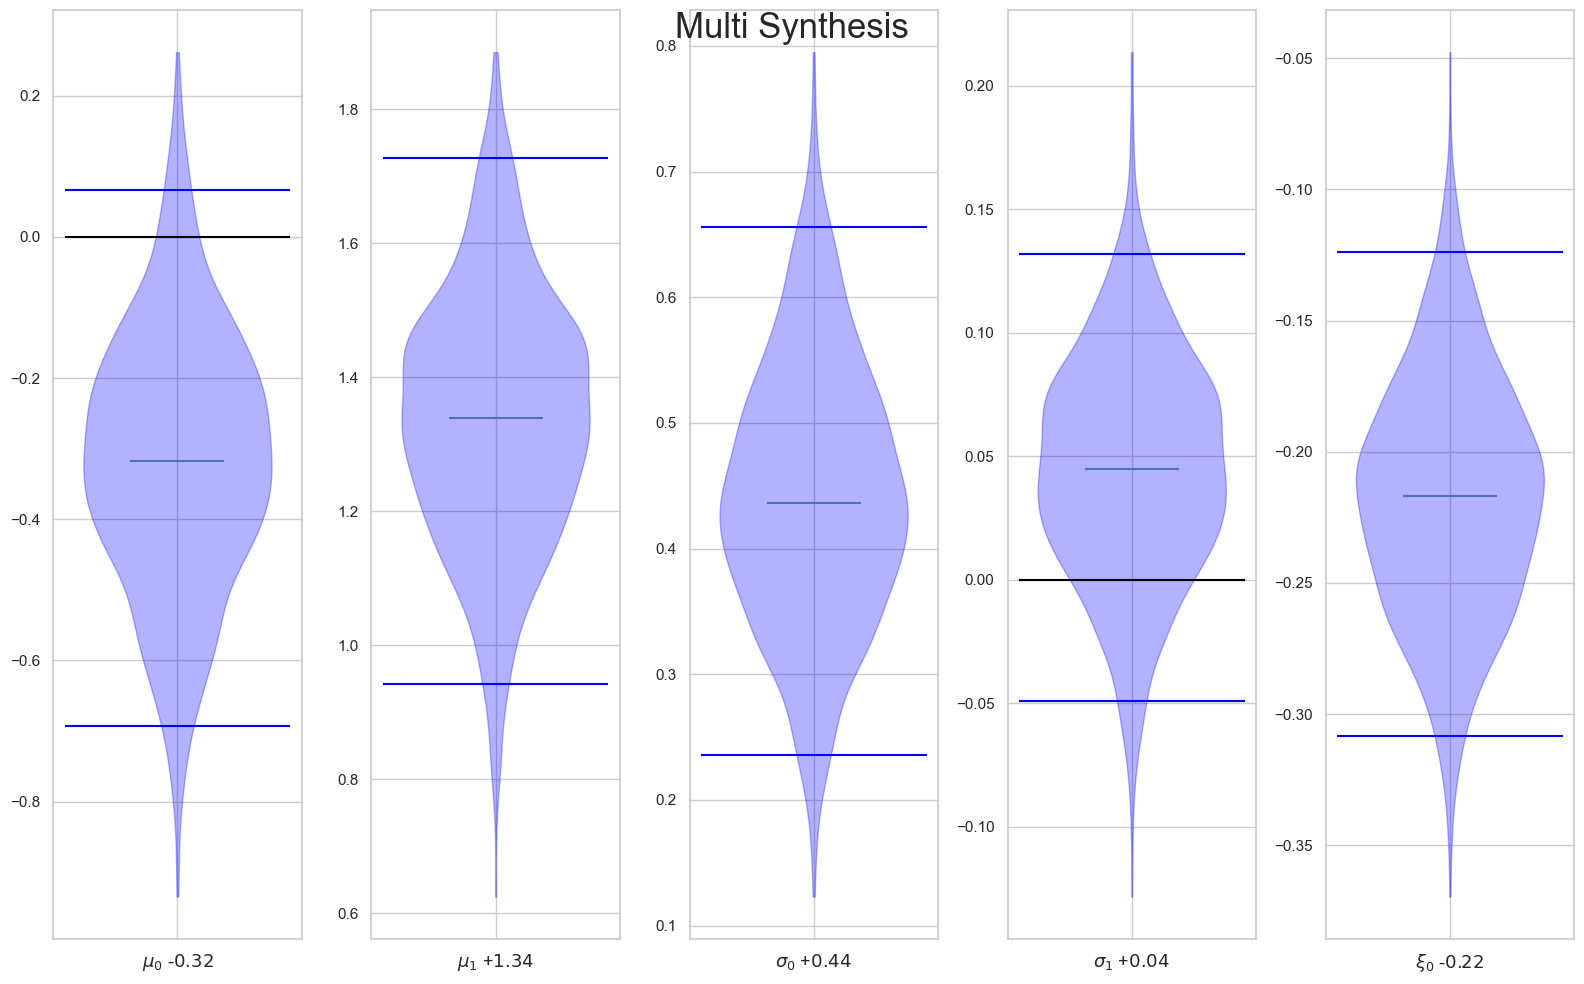

In [18]:
name="Clim_CXCB_MHWG_"+dt_string
para_time(clim_CXCB_MHWG,paramsCXCB_MHWG,pathOut,name="Clim_CXCB_MHWG_"+dt_string)
QQ_plot_Obs_IC(clim_CXCB_MHWG,paramsCXCB_MHWG,Yo,Xo,pathOut,name="Clim_CXCB_MHWG_"+dt_string)
para_distribution_MCMC(clim_CXCB_MHWG, pathOut, name)

In [19]:
%run "Figures_Utils/For_Comp.py"

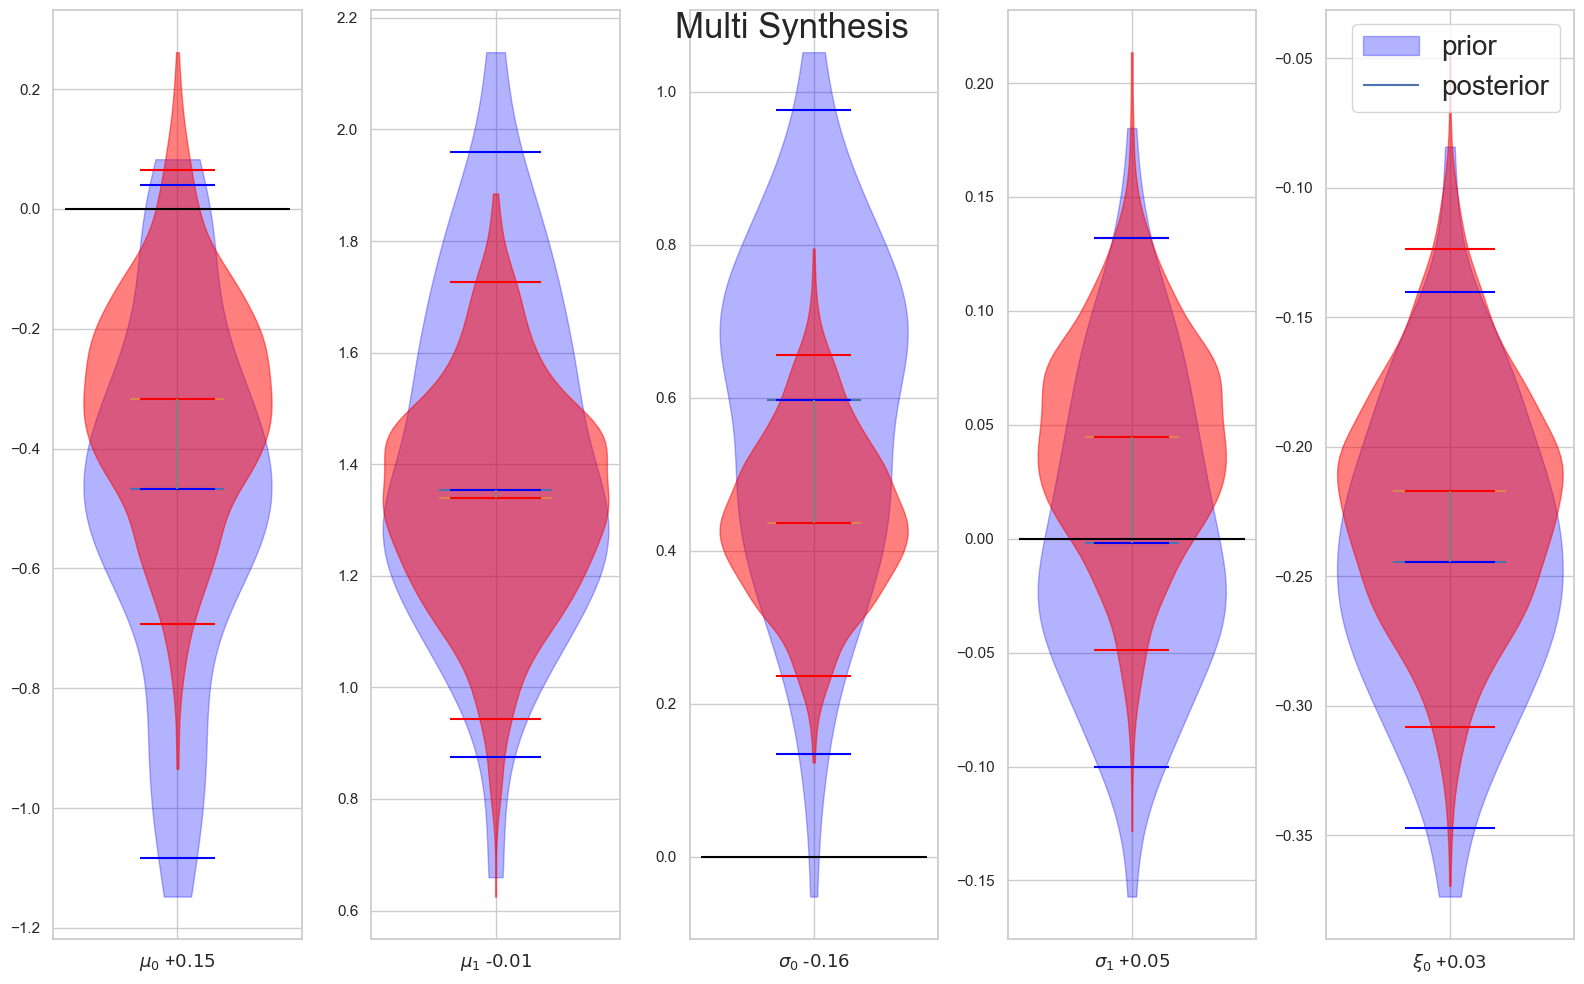

In [20]:
para_distribution_Comp(clim,clim_CXCB_MHWG, pathOut, name,ci=0.05)

In [21]:
params_CX[:,1:,:,:,:].quantile( [ ci / 2 , 1 - ci / 2 , 0.5 ] , dim = "sample" ).assign_coords( quantile = ["ql","qu","BE"] )

<xarray.DataArray (quantile: 3, time: 251, forcing: 2, param: 3, model: 1)>
array([[[[[-3.3825334 ],
          [ 0.98674741],
          [-0.34713547]],

         [[-3.38253345],
          [ 0.98674741],
          [-0.34713547]]],


        [[[-3.37669197],
          [ 0.98806749],
          [-0.34713547]],

         [[-3.37807586],
          [ 0.98713985],
          [-0.34713547]]],


        [[[-3.36029927],
          [ 0.99013637],
...
          [ 1.86355598],
          [-0.24436754]]],


        [[[ 8.02474162],
          [ 1.84634104],
          [-0.24436754]],

         [[-1.97716318],
          [ 1.86354544],
          [-0.24436754]]],


        [[[ 8.15321724],
          [ 1.84112029],
          [-0.24436754]],

         [[-1.97682202],
          [ 1.86353497],
          [-0.24436754]]]]])
Coordinates:
  * time      (time) int64 1850 1851 1852 1853 1854 ... 2096 2097 2098 2099 2100
  * forcing   (forcing) <U1 'F' 'C'
  * param     (param) <U5 'loc' 'scale' 'shape'
  * model     (model) <U23 'Multi_Synthesis'
  * quantile  (quantile) <U2 'ql' 'qu' 'BE'